# Analysis of University Metrics

This notebook shows, how our graphs enables the analysis of university metrics.

## Configuration

We select a colorset according to the universities cooperate color scheme.

In [136]:
UHH_COLOR = "#e2001a"
HAW_COLOR = "#003ca0"
TUHH_COLOR = "#00C1D4"
HSU_COLOR = "#c4004b"

## Import of the Graph

We import the relevant modules and functions. Then, we parse the graph.

In [137]:
from graph.oa_graph import OpenAlexGraph
from graph.analyse_graph import (
    res_to_dataframe,
    UNI_LABELS,
    UNI_QUERY_LIST,
)

g = OpenAlexGraph()
g.parse("out/graph.ttl")  # for performance, keep graph loaded

<Graph identifier=Na153d849b06d426cb6e6720635ea6d94 (<class 'graph.oa_graph.OpenAlexGraph'>)>

## Citations of Universities by Year

We select the amount of citations a university got on its works on a yearly basis. We see an increase in publications for all universities, but combined works of the University of Hamburg have by far the most citations and seem to be growing the fastest. The TUHH and HAW always had a similar output and the HSU produces the least amound of publications.

In [138]:
q = f"""
    SELECT ?inst_name ?year (SUM(?amount) as ?CITATIONS)
    WHERE {{
        {{
            SELECT ?inst_id ?inst_name {{
                ?inst_id a schema:EducationalOrganization ;
                    schema:name ?inst_name .
            }}
        }}
        ?work dbp:institution ?inst_id ;
            dbp:citation [
                dbp:amount ?amount ;
                dbp:year ?year
            ] .

        VALUES ?inst_name {{ {UNI_QUERY_LIST} }}
    }}
    GROUP BY ?inst_name ?year
    ORDER BY ?inst_name DESC(?year)
"""


df = res_to_dataframe(g.query(q))
df = df[df["year"] != 2022]  # ignore 2022 as incomplete year
df.head()

,inst_name,year,CITATIONS
1,Hamburg University of Applied Sciences,2021,509
2,Hamburg University of Applied Sciences,2020,440
3,Hamburg University of Applied Sciences,2019,439
4,Hamburg University of Applied Sciences,2018,364
5,Hamburg University of Applied Sciences,2017,307


C:\Users\alex_\AppData\Local\Temp\ipykernel_11756\249723431.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hsu = hsu.append(


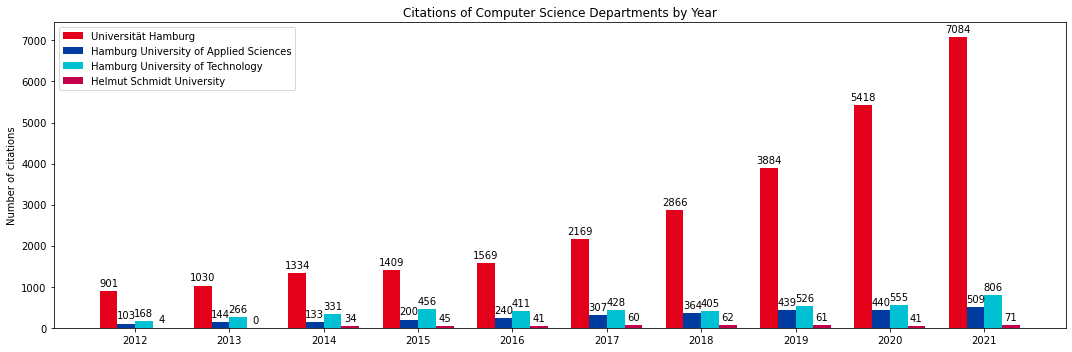

In [140]:
import matplotlib.pyplot as plt
import numpy as np

df = df.sort_values("year", ascending=True)

labels = df["year"].unique()
uhh = df[df["inst_name"] == UNI_LABELS["uhh"]]
haw = df[df["inst_name"] == UNI_LABELS["haw"]]
tuhh = df[df["inst_name"] == UNI_LABELS["tuhh"]]
hsu = df[df["inst_name"] == UNI_LABELS["hsu"]]
hsu = hsu.append(
    {"inst_name": "Helmut Schmidt University", "year": 2013, "CITATIONS": 0},
    ignore_index=True
).sort_values(by="year", axis=0)

x = np.arange(len(labels))  # the label locations
width = 0.75  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 5))
rects1 = ax.bar(x - width/4 - width/8, uhh["CITATIONS"], width/4, label=UNI_LABELS["uhh"], color=UHH_COLOR)
rects2 = ax.bar(x - width/8, haw["CITATIONS"], width/4, label=UNI_LABELS["haw"], color=HAW_COLOR)
rects3 = ax.bar(x + width/8, tuhh["CITATIONS"], width/4, label=UNI_LABELS["tuhh"], color=TUHH_COLOR)
rects4 = ax.bar(x + width/4 + width/8, hsu["CITATIONS"], width/4, label=UNI_LABELS["hsu"], color=HSU_COLOR)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
ax.bar_label(rects4, padding=3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of citations')
ax.set_title('Citations of Computer Science Departments by Year')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

### Putting things into relation

The UHH has the most citations for their combined works, but also by far the most authors and works of all the universities. Pumping out publications is not a necessary a good metric for scientific quality. Let's put the citations into relation with the number of papers a university published each year. The graph below shows us the average number of citations per paper for every year. From 2013 to 2017, the HAW had the highest average number of citations per paper. After 2017, the UHH and HSU seemed to improve their quality of work, overtaking the HAW. Although the TUHH seemed to be consistently improving over the last years, in 2021 their citations per work went down about 43%. On the other side, the UHH almost doubled their citations per paper over the pandemic years 2020 and 2021. For the HSU, the number of citations even increased threefold in 2020 and stayed on similar level as the UHH in 2021. Over the last two years, UHH and HSU seemed to put out the most scientific relevant publications.

In [141]:
import pandas as pd

q = fr"""
    SELECT
        (SAMPLE(?inst_name) as ?INSTITUTION)
        (SAMPLE(?year) as ?YEAR)
        (COUNT(?id_work) as ?PUBLICATIONS)
    WHERE {{
        ?id_work a schema:Article;
            schema:datePublished ?pub_date ;
            dbp:institution [
                schema:name ?inst_name
            ] .

        VALUES ?inst_name {{ {UNI_QUERY_LIST} }}
    }}
    GROUP BY ?inst_name (REPLACE(str(?pub_date), "(\\d*)-.*", "$1") as ?year)
"""
res = g.query(q)
df_pubs = res_to_dataframe(res)
df_pubs = df_pubs[df_pubs["YEAR"].isin(df["year"].values)]
df = pd.merge(df, df_pubs, right_on=["INSTITUTION", "YEAR"], left_on=["inst_name", "year"])[["INSTITUTION", "YEAR", "CITATIONS", "PUBLICATIONS"]]
df["CIT_PER_PUB"] = df["CITATIONS"] / df["PUBLICATIONS"]

df.head()

,INSTITUTION,YEAR,CITATIONS,PUBLICATIONS,CIT_PER_PUB
0,Hamburg University of Technology,2012,168,42,4.000000
1,Helmut Schmidt University,2012,4,1,4.000000
2,Hamburg University of Applied Sciences,2012,103,26,3.961538
3,Universität Hamburg,2012,901,103,8.747573
4,Hamburg University of Technology,2013,266,23,11.565217


C:\Users\alex_\AppData\Local\Temp\ipykernel_11756\2739840668.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hsu = hsu.append(


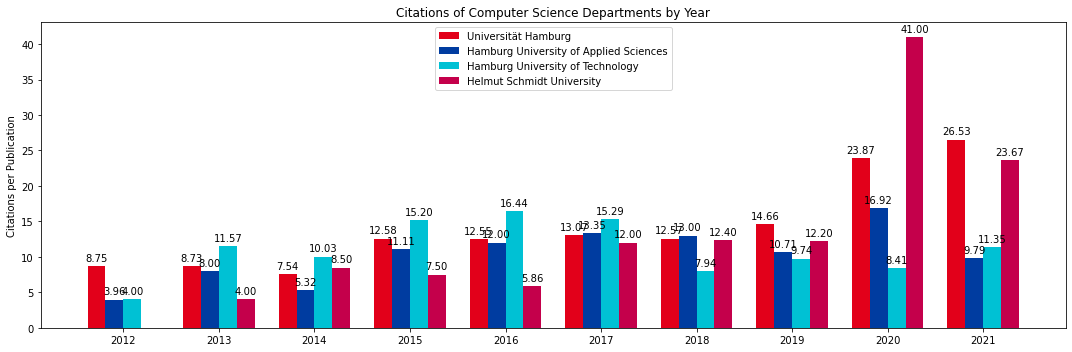

In [142]:
labels = df["YEAR"].unique()
uhh = df[df["INSTITUTION"] == UNI_LABELS["uhh"]]
haw = df[df["INSTITUTION"] == UNI_LABELS["haw"]]
tuhh = df[df["INSTITUTION"] == UNI_LABELS["tuhh"]]
hsu = df[df["INSTITUTION"] == UNI_LABELS["hsu"]]
hsu = hsu.append(
    {"inst_name": "Helmut Schmidt University", "year": 2013, "CITATIONS": 0},
    ignore_index=True
).sort_values(by="year", axis=0)

x = np.arange(len(labels))  # the label locations
width = 0.75  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 5))
rects1 = ax.bar(x - width/4 - width/8, uhh["CIT_PER_PUB"], width/4, label=UNI_LABELS["uhh"], color=UHH_COLOR)
rects2 = ax.bar(x - width/8, haw["CIT_PER_PUB"], width/4, label=UNI_LABELS["haw"], color=HAW_COLOR)
rects3 = ax.bar(x + width/8, tuhh["CIT_PER_PUB"], width/4, label=UNI_LABELS["tuhh"], color=TUHH_COLOR)
rects4 = ax.bar(x + width/4 + width/8, hsu["CIT_PER_PUB"], width/4, label=UNI_LABELS["hsu"], color=HSU_COLOR)

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')
ax.bar_label(rects3, padding=3, fmt='%.2f')
ax.bar_label(rects4, padding=3, fmt='%.2f')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Citations per Publication')
ax.set_title('Citations of Computer Science Departments by Year')
ax.set_xticks(x, labels)
ax.legend()


fig.tight_layout()

plt.show()

## Finding outliers

While the number of citations per paper is impressively high for the UHH over the last two years, this might be carried by a few papers that have been extraordinarily popular in that timeframe. To see the potential effect of outliers, lets first query the graph for an ungrouped list of all the papers and their citations by year.

In [143]:
q = f"""
    SELECT ?INSTITUTION ?PAPER ?YEAR (?amount as ?CITATIONS)
    WHERE {{
        ?PAPER a schema:Article ;
            dbp:institution [
                schema:name ?INSTITUTION
            ] ;
            dbp:citation [
                dbp:amount ?amount ;
                dbp:year ?YEAR
            ] .

        VALUES ?INSTITUTION {{ {UNI_QUERY_LIST} }}
    }}
"""
res = g.query(q)
df = res_to_dataframe(res)
df.head()

,PAPER,YEAR,INSTITUTION,CITATIONS
0,https://openalex.org/W107147422,2017,Helmut Schmidt University,2
1,https://openalex.org/W107147422,2014,Helmut Schmidt University,1
2,https://openalex.org/W107147422,2015,Helmut Schmidt University,1
3,https://openalex.org/W107147422,2019,Helmut Schmidt University,1
4,https://openalex.org/W107147422,2016,Helmut Schmidt University,2


Plotting the citations per work as a boxplot for every year, we see the top 1% most cited papers as the dots on the Boxplot.

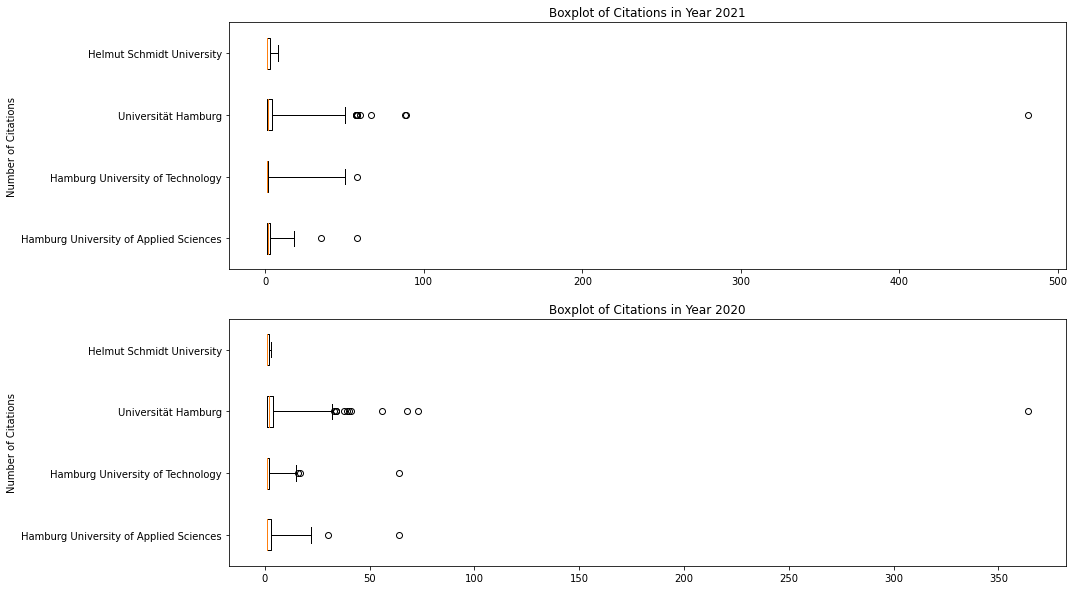

In [144]:
last_n_years = 2

fig, ax = plt.subplots(last_n_years, figsize=(15, 5 * last_n_years))

for i in range(last_n_years):
    ax[i].boxplot(
        x = [df[(df["INSTITUTION"] == UNI_LABELS[uni]) & (df["YEAR"] == 2021 - i)]["CITATIONS"] for uni in UNI_LABELS.keys()],
        widths=0.5,
        labels=UNI_LABELS.values(),
        whis=[0, 99],
        vert=False,
    )
    ax[i].set_title(f"Boxplot of Citations in Year {2021 - i}")
    ax[i].set_ylabel("Number of Citations")

plt.show()

### Filtering the data

We filter the data by removing the top 1% most cited publications for our analysis. This should reduce the bias in our metrics for papers that have received unusual attention and do not represent the average works of the universities. After removing the outliers, the Boxplots are much less squashed, indicating a somewhat less biased distribution.

In [145]:
df_li = []
for year in df["YEAR"].unique():
    for uni in UNI_LABELS.keys():
        sub_df = df[(df["INSTITUTION"] == UNI_LABELS[uni]) & (df["YEAR"] == year)]
        sub_df = sub_df[sub_df["CITATIONS"] < sub_df["CITATIONS"].quantile(.99)]
        df_li.append(sub_df)

df_filtered = pd.concat(df_li)
df_filtered.head()

,PAPER,YEAR,INSTITUTION,CITATIONS
278,https://openalex.org/W1506447143,2017,Hamburg University of Applied Sciences,1
424,https://openalex.org/W195130104,2017,Hamburg University of Applied Sciences,1
509,https://openalex.org/W1998002212,2017,Hamburg University of Applied Sciences,2
862,https://openalex.org/W2085682592,2017,Hamburg University of Applied Sciences,3
1020,https://openalex.org/W2125574012,2017,Hamburg University of Applied Sciences,2


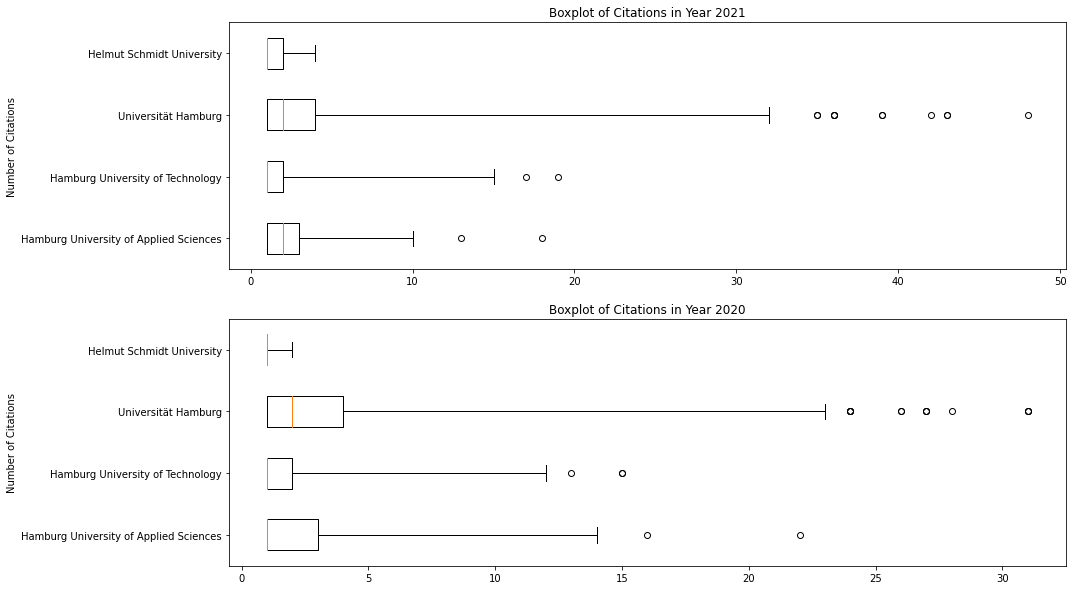

In [146]:
last_n_years = 2

fig, ax = plt.subplots(last_n_years, figsize=(15, 5 * last_n_years))

for i in range(last_n_years):
    ax[i].boxplot(
        x = [df_filtered[(df_filtered["INSTITUTION"] == UNI_LABELS[uni]) & (df_filtered["YEAR"] == 2021 - i)]["CITATIONS"] for uni in UNI_LABELS.keys()],
        widths=0.5,
        labels=UNI_LABELS.values(),
        whis=[0, 99],
        vert=False,
    )
    ax[i].set_title(f"Boxplot of Citations in Year {2021 - i}")
    ax[i].set_ylabel("Number of Citations")

plt.show()

### Filtered analysis

After we have removed the outliers, we can now repeat the analysis from the beginning.

In [147]:
# Sum of filtered citations
df_filtered = df_filtered.groupby(by=["INSTITUTION", "YEAR"]).sum()
df_filtered.at[(UNI_LABELS["hsu"], 2013), "CITATIONS"] = 0

# Count of publications pre-filtered
df_filtered = pd.merge(df_filtered, df_pubs, on=["INSTITUTION", "YEAR"])

For 2021, the absolute number of citations as well as the number of citations per paper for the UHH and the HAW both decreased by about 20% when removing outliers. For the TUHH and HSU, it even decreased by more than 30%. The UHH ist still by far the most cited university each year in absolute terms, followed by the HAW, TUHH and tailed by the HSU.

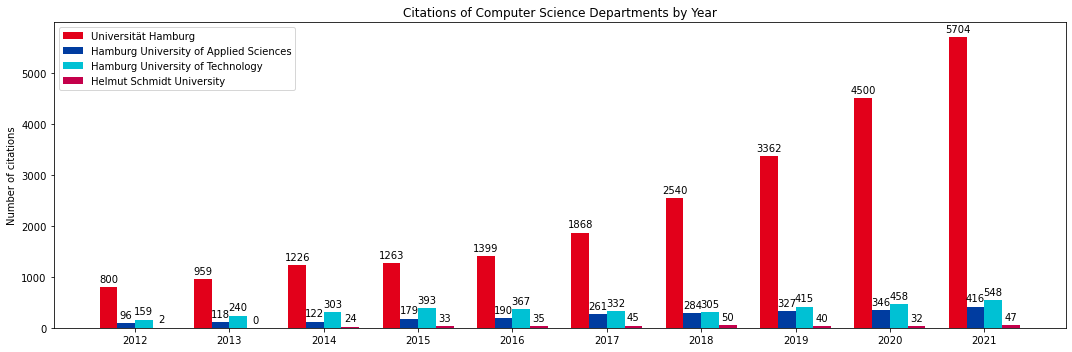

In [149]:
import matplotlib.pyplot as plt
import numpy as np

df_filtered = df_filtered[df_filtered["YEAR"] != 2022]
df_filtered = df_filtered.sort_values("YEAR", ascending=True)

labels = df_filtered["YEAR"].unique()
uhh = df_filtered[df_filtered["INSTITUTION"] == UNI_LABELS["uhh"]]
haw = df_filtered[df_filtered["INSTITUTION"] == UNI_LABELS["haw"]]
tuhh = df_filtered[df_filtered["INSTITUTION"] == UNI_LABELS["tuhh"]]
hsu = df_filtered[df_filtered["INSTITUTION"] == UNI_LABELS["hsu"]]

x = np.arange(len(labels))  # the label locations
width = 0.75  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 5))
rects1 = ax.bar(x - width/4 - width/8, uhh["CITATIONS"], width/4, label=UNI_LABELS["uhh"], color=UHH_COLOR)
rects2 = ax.bar(x - width/8, haw["CITATIONS"], width/4, label=UNI_LABELS["haw"], color=HAW_COLOR)
rects3 = ax.bar(x + width/8, tuhh["CITATIONS"], width/4, label=UNI_LABELS["tuhh"], color=TUHH_COLOR)
rects4 = ax.bar(x + width/4 + width/8, hsu["CITATIONS"], width/4, label=UNI_LABELS["hsu"], color=HSU_COLOR)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
ax.bar_label(rects4, padding=3)


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of citations')
ax.set_title('Citations of Computer Science Departments by Year')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

The same patterns holds for the average amount of citations per paper. As the TUHH seems to be carried the most by a few highly cited papers, the HAW actually performs slightly better than the TUHH last year when removing those outliers. As the HSU has more distorting outliers, the UHH gains in citations per publications after filtering.

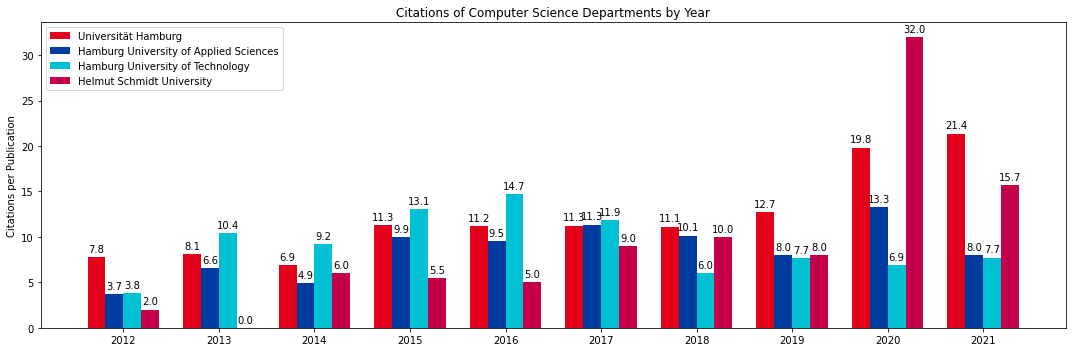

In [154]:
df_filtered["CIT_PER_PUB"] = df_filtered["CITATIONS"] / df_filtered["PUBLICATIONS"]

labels = df_filtered["YEAR"].unique()
uhh = df_filtered[df_filtered["INSTITUTION"] == UNI_LABELS["uhh"]]
haw = df_filtered[df_filtered["INSTITUTION"] == UNI_LABELS["haw"]]
tuhh = df_filtered[df_filtered["INSTITUTION"] == UNI_LABELS["tuhh"]]
hsu = df_filtered[df_filtered["INSTITUTION"] == UNI_LABELS["hsu"]]

x = np.arange(len(labels))  # the label locations
width = 0.75  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 5))
rects1 = ax.bar(x - width/4 - width/8, uhh["CIT_PER_PUB"], width/4, label=UNI_LABELS["uhh"], color=UHH_COLOR)
rects2 = ax.bar(x - width/8, haw["CIT_PER_PUB"], width/4, label=UNI_LABELS["haw"], color=HAW_COLOR)
rects3 = ax.bar(x + width/8, tuhh["CIT_PER_PUB"], width/4, label=UNI_LABELS["tuhh"], color=TUHH_COLOR)
rects4 = ax.bar(x + width/4 + width/8, hsu["CIT_PER_PUB"], width/4, label=UNI_LABELS["hsu"], color=HSU_COLOR)

ax.bar_label(rects1, padding=3, fmt='%.1f')
ax.bar_label(rects2, padding=3, fmt='%.1f')
ax.bar_label(rects3, padding=3, fmt='%.1f')
ax.bar_label(rects4, padding=3, fmt='%.1f')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Citations per Publication')
ax.set_title('Citations of Computer Science Departments by Year')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()
plt.savefig("img/metric_expl.png")
plt.show()

<Figure size 432x288 with 0 Axes>